# Resumen Ejecutivo: Segmentación de la Calidad del Agua Subterránea Mediante Clustering No Supervisado

### Introducción y Objetivos

Este documento detalla el proceso de análisis y modelado de un conjunto de datos sobre la calidad del agua de 1,068 sitios de monitoreo de aguas subterráneas en México durante el año 2020. El **objetivo principal** fue utilizar técnicas de machine learning no supervisado (clustering) para identificar y caracterizar patrones o "perfiles" de calidad del agua existentes en los datos. La meta final no era solo agrupar los datos, sino **traducir estas agrupaciones matemáticas en perfiles descriptivos, interpretables y accionables** que pudieran informar sobre la gestión de recursos hídricos.

### Metodología de Análisis

El proyecto se ejecutó siguiendo un pipeline estructurado de ciencia de datos, que abarcó desde la limpieza inicial hasta la interpretación final del modelo:

1.  **Preparación y Limpieza de Datos:** Se realizó un exhaustivo proceso de limpieza que incluyó la corrección de tipos de datos, el manejo de formatos no estándar (ej. valores `<0.01`) y una estrategia de **imputación inteligente** para los valores ausentes.
2.  **Análisis Exploratorio de Datos (EDA):** Se investigaron las distribuciones, correlaciones y patrones espaciales de las variables para comprender la estructura fundamental de los datos y guiar las decisiones de modelado.
3.  **Ingeniería de Características:** Basado en el EDA, se seleccionaron las características más informativas, se aplicaron transformaciones no lineales (logarítmicas) para corregir el sesgo de los datos y se estandarizaron todas las variables para asegurar que contribuyeran de manera equitativa al modelo.
4.  **Modelado de Clustering:** Se utilizó el algoritmo K-Means para segmentar los datos. Se emplearon técnicas de diagnóstico (Método del Codo y Puntuación de Silueta) para determinar el número óptimo de clusters.
5.  **Interpretación y Visualización:** La fase final se centró en la caracterización de los clusters resultantes, utilizando metadatos externos para traducir los resultados numéricos en perfiles descriptivos y visualizando su distribución geográfica.

### El Rol Clave de los Metadatos (Archivo `Escalas_subterranea.csv`)

Un componente fundamental del proyecto fue el uso de un segundo archivo que contenía las **reglas de negocio** para clasificar la calidad del agua. Este archivo fue procesado y convertido en un diccionario estructurado (`quality_rules`) que funcionó como una "guía de traducción" en dos momentos críticos:

1.  **Durante la Limpieza de Datos:** Al rellenar valores numéricos faltantes, este diccionario permitió **inferir y rellenar automáticamente la etiqueta de calidad categórica correspondiente**, garantizando la consistencia lógica del conjunto de datos.
2.  **Durante la Interpretación del Modelo:** Una vez que el modelo K-Means generó los centroides (el "centro" numérico de cada cluster), este diccionario fue indispensable para **traducir los valores promedio de cada cluster a descripciones humanas comprensibles** (ej. un valor de Arsénico de 0.045 mg/L se tradujo a "No apta como FAAP"). Este paso transformó la salida matemática abstracta del modelo en insights de negocio.

### Hallazgos y Decisiones Clave

-   **Preprocesamiento Crítico:** El EDA reveló un fuerte sesgo en las distribuciones y una alta correlación entre variables de salinidad. Esto condujo a dos decisiones clave: la **aplicación de una transformación logarítmica** a las mediciones y la **eliminación de una columna redundante** (`SDT_M_mg/L`).
-   **Determinación del Número Óptimo de Clusters:** El análisis combinado del Método del Codo y la Puntuación de Silueta, junto con la observación de cómo el modelo aislaba outliers, llevó a la selección de **k=11 clusters** como la solución óptima. Esta elección maximizó la separabilidad matemática de los grupos y permitió una caracterización granular de los perfiles de agua, incluyendo la identificación de anomalías extremas.
-   **Identificación de Perfiles Geográficos:** El modelo, sin ninguna información previa sobre geografía (más allá de las coordenadas), logró identificar clusters que se correspondían fuertemente con regiones hidrogeológicas conocidas. Por ejemplo, se identificó un perfil de **"Agua Dura de Buena Calidad" casi exclusivo de la Península de Yucatán** y perfiles de **"Contaminación por Arsénico y Flúor" concentrados en el norte y noroeste del país**.

### Conclusión General

El análisis fue un éxito rotundo. Se logró segmentar el conjunto de datos en **11 perfiles de calidad del agua distintos, interpretables y geográficamente coherentes**. Estos perfiles van desde patrones comunes de agua dura o suave hasta grupos específicos definidos por contaminación de metales pesados (Arsénico, Plomo) y minerales (Flúor), e incluso se aislaron las 3 muestras más anómalas de todo el dataset.

El resultado final no es solo un modelo entrenado, sino un **sistema de clasificación validado** que puede ser utilizado para caracterizar nuevas muestras de agua y una serie de **insights accionables** que pueden guiar esfuerzos de monitoreo, tratamiento y gestión de los recursos hídricos a nivel regional.

### Sección 1: Configuración del Entorno y Carga de Datos

#### Resumen Ejecutivo de la Sección

El objetivo de esta sección inicial fue establecer el entorno de trabajo, cargar las fuentes de datos primarias y secundarias, y realizar una evaluación diagnóstica inicial de la calidad y estructura de los datos. Este paso es fundamental para definir la estrategia de preprocesamiento y análisis subsiguiente.

#### Metodología y Ejecución

1.  **Configuración del Entorno:** Se importaron las librerías estándar de Python para el análisis de datos (`pandas`, `numpy`), visualización (`matplotlib`, `seaborn`) y manipulación de texto (`re`). Adicionalmente, se configuraron los parámetros estéticos para las visualizaciones.

2.  **Carga del Conjunto de Datos Principal:** El archivo `Datos_de_calidad_del_agua_..._2020.csv` fue cargado en un DataFrame de pandas (`df`). Se especificó la codificación `latin-1` para asegurar la correcta interpretación de caracteres especiales del idioma español.

3.  **Carga de Metadatos:** El archivo de reglas de negocio, `Escalas_subterranea.csv`, fue cargado como una cadena de texto cruda (`criteria_raw_text`), dado que su formato no es tabular estándar y requiere un parseo personalizado en la siguiente sección.

4.  **Inspección Inicial:** Se ejecutaron los comandos `df.head()` y `df.info()` para obtener una vista preliminar de la estructura, los tipos de datos y la completitud del conjunto de datos principal.

#### Análisis de Resultados

La ejecución de la celda fue exitosa y la inspección inicial reveló los siguientes puntos críticos que guiarán el resto del análisis:

*   **Dimensiones del Dataset:** El conjunto de datos principal consta de **1068 registros y 57 columnas**.
*   **Identificación de Tipos de Datos Incorrectos:** El resumen de `df.info()` mostró que múltiples columnas que representan mediciones cuantitativas (ej. `AS_TOT_mg/L`) fueron cargadas con el tipo de dato `object`. Esto confirma la presencia de caracteres no numéricos que deben ser procesados.
*   **Detección de Valores Ausentes:** El conteo de valores no nulos evidenció la presencia de datos faltantes en varias columnas. Destaca la columna `SDT_mg/L`, la cual se encuentra completamente vacía, y otras con ausencias parciales que requerirán un tratamiento de imputación.

#### Conclusión de la Sección

Esta sección ha establecido exitosamente la base para el proyecto. Los datos han sido cargados y, a través de una inspección inicial, se ha generado un diagnóstico claro de los desafíos de calidad de datos que deben ser abordados: la corrección de tipos de datos, el manejo de formatos no estándar y la imputación de valores ausentes.

In [121]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json

# Set plot style and figure size for better aesthetics
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# --- 1. Load the main dataset from the CSV file ---
# Replace 'your_data_file.csv' with the actual path to your data file.
main_file_path = 'Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'
try:
    df = pd.read_csv(main_file_path, encoding='latin-1')
    print(f"Successfully loaded main dataset from '{main_file_path}'.")
    print(f"Shape of the dataset: {df.shape}")
except FileNotFoundError:
    print(f"Error: The file was not found at '{main_file_path}'")
    print("Please update the 'main_file_path' variable with the correct location of your CSV file.")
    df = None # Set df to None to prevent further errors

# --- 2. Load the metadata/criteria definitions from its CSV file ---
criteria_file_path = 'Escalas_subterranea.csv'
try:
    # We read the file line by line as its structure is not a standard CSV
    with open(criteria_file_path, 'r', encoding='latin-1') as f:
        criteria_raw_text = f.read()
    print(f"Successfully loaded criteria metadata from '{criteria_file_path}'.")
except FileNotFoundError:
    print(f"Error: The file '{criteria_file_path}' was not found.")
    print("Please update the 'criteria_file_path' variable with the correct location.")
    criteria_raw_text = None

# Display initial info from the main dataframe
if df is not None:
    display(df.head())
    df.info()

Successfully loaded main dataset from 'Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'.
Shape of the dataset: (1068, 57)
Successfully loaded criteria metadata from 'Escalas_subterranea.csv'.


,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

### Sección 2: Procesamiento de Metadatos y Definición de Funciones de Clasificación

#### Resumen Ejecutivo de la Sección

El objetivo fundamental de esta sección fue la ingeniería de datos aplicada a los metadatos del proyecto. Se desarrolló un proceso para transformar las reglas de negocio, provistas en el archivo `Escalas_subterranea.csv`, desde un formato de texto semi-estructurado a una estructura de datos programática y consultable. Adicionalmente, se implementó una función de clasificación que utiliza estas reglas para la evaluación automatizada de la calidad del agua.

#### Metodología y Ejecución

1.  **Mapeo de Entidades:** Para garantizar la interoperabilidad entre el conjunto de datos principal y los metadatos, se establecieron diccionarios de mapeo (`param_map`, `header_word_map`). Estos aseguran una correspondencia unívoca y robusta entre las abreviaturas de los parámetros, los nombres completos de las columnas y los descriptores textuales en los archivos.

2.  **Extracción y Estructuración de Reglas:** Se diseñó la función `parse_criteria` para procesar el contenido de los metadatos. Mediante el uso de expresiones regulares (`regex`), esta función extrae de cada línea de texto los componentes esenciales de una regla de clasificación:
    *   **Etiqueta de Calidad:** La clasificación categórica final (ej. "Apta como FAAP").
    *   **Límites Numéricos:** Los umbrales cuantitativos que definen el rango de aplicación de la etiqueta (ej. `[0.01, 0.025]`).
    
    El producto de esta función es el diccionario `quality_rules`, un objeto estructurado que sirve como base de conocimiento para el sistema.

3.  **Implementación de la Lógica de Clasificación:** Se desarrolló la función `get_quality_label_from_value`, la cual encapsula la lógica para evaluar un valor numérico de entrada contra las reglas almacenadas en `quality_rules`. Dados un parámetro y un valor, la función retorna la etiqueta de calidad categórica correspondiente.

#### Conclusión de la Sección

El resultado de esta fase es doble: se ha creado un **repositorio estructurado de las reglas de negocio (`quality_rules`)** y una **herramienta funcional (`get_quality_label_from_value`)** para su aplicación. La correcta estructuración de las reglas para el parámetro Arsénico, mostrada en la salida de la celda, valida el éxito del proceso de parseo.

Esta capacidad de clasificar programáticamente los datos numéricos es un pilar para las siguientes etapas del análisis, particularmente para la imputación consistente de datos faltantes y, de manera crucial, para la interpretación y caracterización de los clusters que se generarán en la fase de modelado.

In [122]:
# Create a mapping from the short parameter names in the metadata to the full column names in the main DataFrame
param_map = {
    'COLI_FEC': 'COLI_FEC_NMP/100_mL', 'SDT_salin': 'CALIDAD_SDT_salin',
    'SDT_ra': 'CALIDAD_SDT_ra', 'CR': 'CR_TOT_mg/L', 'CONDUC': 'CONDUCT_mS/cm',
    'CD': 'CD_TOT_mg/L', 'AS': 'AS_TOT_mg/L', 'ALC': 'ALC_mg/L',
    'PB': 'PB_TOT_mg/L', 'N_NO3': 'N_NO3_mg/L', 'MN': 'MN_TOT_mg/L',
    'HG': 'HG_TOT_mg/L', 'FLUO': 'FLUORUROS_mg/L', 'FE': 'FE_TOT_mg/L',
    'DUR': 'DUR_mg/L', 'SDT': 'SDT_M_mg/L'
}

# Invert map for easy lookup from full column name
column_to_param_map = {v: k for k, v in param_map.items()}

# --- NEW: Robust mapping from Spanish header word to our short key ---
header_word_map = {
    'COLIFORMES': 'COLI_FEC', 'CROMO': 'CR', 'CONDUCTIVIDAD': 'CONDUC',
    'CADMIO': 'CD', 'ARSENICO': 'AS', 'ALCALINIDAD': 'ALC', 'PLOMO': 'PB',
    'NITRATOS': 'N_NO3', 'MANGANESO': 'MN', 'MERCURIO': 'HG',
    'FLUORUROS': 'FLUO', 'HIERRO': 'FE', 'DUREZA': 'DUR'
}

def parse_criteria(criteria_string):
    """Parses the criteria text into a structured dictionary."""
    if criteria_string is None:
        print("Criteria text is not available. Cannot parse.")
        return None
        
    lines = criteria_string.strip().split('\n')
    parsed_rules = {}
    current_param_key = None

    for line in lines:
        parts = [p.strip() for p in line.split(',', 2)]
        
        if parts[0].startswith('CALIDAD DEL AGUA PARA'):
            header_text = parts[0]
            current_param_key = None # Reset for each new header
            if "SALINIZACION" in header_text: current_param_key = "SDT_salin"
            elif "RIEGO AGRICOLA" in header_text: current_param_key = "SDT_ra"
            else:
                # *** THIS IS THE CORRECTED LOGIC ***
                # Iterate through our new robust map
                for word, key in header_word_map.items():
                    if word in header_text:
                        current_param_key = key
                        break # Found a match, stop looking
            if current_param_key:
                parsed_rules[current_param_key] = []

        elif current_param_key and len(parts) > 1 and not parts[0].lower() == 'criterio':
            quality_label, rule_text = parts[0], parts[1]
            numbers = [float(x) for x in re.findall(r'[-+]?\d*\.\d+|\d+', rule_text)]
            if current_param_key in parsed_rules:
                parsed_rules[current_param_key].append({'label': quality_label, 'text': rule_text, 'numbers': numbers})
    return parsed_rules

# Parse the rules from the text loaded in Section 1
quality_rules = parse_criteria(criteria_raw_text)

if quality_rules and quality_rules.get('AS'):
    print("Successfully parsed metadata. Example for 'Arsenic (AS)':")
    print(json.dumps(quality_rules.get('AS', {}), indent=2))
else:
    print("Could not parse metadata correctly. Please check the parsing logic and file content.")
    print("Current parsed state for 'AS':", quality_rules.get('AS', 'Not Found'))


# --- HELPER FUNCTION DEFINITION ---
def get_quality_label_from_value(param_key, value, rules_dict):
    """Finds the correct quality label for a given numerical value based on the parsed rules."""
    if not rules_dict or param_key not in rules_dict:
        return "N/A"
    
    for rule in rules_dict[param_key]:
        text, nums = rule['text'].lower(), rule['numbers']
        try:
            if 'menor o igual a' in text and len(nums) == 1:
                if value <= nums[0]: return rule['label']
            elif 'menor de' in text and 'mayor o igual a' in text and len(nums) == 2:
                 if nums[0] <= value < nums[1]: return rule['label']
            elif 'menor a' in text and len(nums) == 1:
                if value < nums[0]: return rule['label']
            elif 'mayor o igual a' in text and 'menor o igual a' in text and len(nums) == 2:
                if nums[0] <= value <= nums[1]: return rule['label']
            elif 'mayor de' in text and 'menor o igual a' in text and len(nums) == 2:
                if nums[0] < value <= nums[1]: return rule['label']
            elif 'mayor de' in text and len(nums) == 1:
                if value > nums[0]: return rule['label']
            elif 'mayor o igual a' in text and len(nums) == 1:
                if value >= nums[0]: return rule['label']
        except (TypeError, IndexError):
            continue
    return "No matching rule"

Successfully parsed metadata. Example for 'Arsenic (AS)':
[
  {
    "label": "Potable - Excelente",
    "text": "AS menor o igual a 0.01",
    "numbers": [
      0.01
    ]
  },
  {
    "label": "Apta como FAAP",
    "text": "AS mayor de 0.01 y menor o igual a 0.025",
    "numbers": [
      0.01,
      0.025
    ]
  },
  {
    "label": "No apta como FAAP",
    "text": "AS mayor de 0.025",
    "numbers": [
      0.025
    ]
  }
]


### Sección 3: Limpieza y Preprocesamiento de Datos

#### Resumen Ejecutivo de la Sección

El propósito de esta sección fue ejecutar un pipeline de limpieza de datos exhaustivo para transformar el conjunto de datos crudo en un formato analíticamente viable. El proceso abordó tres problemas principales de calidad de datos identificados previamente: tipos de datos incorrectos, formatos de valor no numéricos y la presencia de valores ausentes.

#### Metodología y Ejecución

1.  **Corrección de Tipos de Datos:** Se identificaron las columnas que, a pesar de representar mediciones cuantitativas, fueron cargadas con tipo `object` debido a la presencia de caracteres no numéricos (ej. `'<'`). Se aplicó una función (`clean_numeric`) para eliminar dichos caracteres y convertir estas columnas a un tipo de dato numérico (`float64`).

2.  **Manejo de Valores Ausentes:**
    *   **Análisis Inicial:** Se generó un informe detallado de todos los valores ausentes en el dataset.
    *   **Eliminación de Columnas:** La columna `SDT_mg/L` fue eliminada por carecer completamente de datos (100% de valores nulos).
    *   **Imputación Inteligente:** Para las columnas con ausencias parciales, se implementó una estrategia de imputación robusta. Los valores numéricos faltantes fueron rellenados con la **mediana** de su respectiva columna, una medida de tendencia central resistente a valores atípicos. De manera crucial, se utilizó la función `get_quality_label_from_value` (definida en la Sección 2) para inferir y rellenar la etiqueta categórica (`CALIDAD_*`) correspondiente, garantizando así la consistencia lógica entre los datos numéricos y categóricos.

#### Conclusión de la Sección

El proceso fue exitoso, como lo demuestra el informe final de `df.info()`. El resultado es un DataFrame, `df_cleaned`, que está **completo, limpio y lógicamente consistente**. Todas las columnas numéricas tienen el tipo de dato correcto y no quedan valores nulos en ninguna de las columnas clave.

Este DataFrame `df_cleaned` constituye la base sólida y confiable sobre la cual se construirán todos los análisis visuales y estadísticos en las secciones posteriores.

In [123]:
if df is not None:
    df_cleaned = df.copy()

    # Define which columns should be numeric measurements
    numerical_cols = [
        'LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_mg/L', 
        'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 
        'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L',
        'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L'
    ]
    
    # Function to convert object columns with '<' symbols to numeric
    def clean_numeric(value):
        if isinstance(value, str):
            value = value.replace('<', '').strip()
        return pd.to_numeric(value, errors='coerce')

    # Apply the cleaning function to all potential numerical columns
    for col in numerical_cols:
        if col in df_cleaned.columns and df_cleaned[col].dtype == 'object':
            df_cleaned[col] = df_cleaned[col].apply(clean_numeric)

    # --- Handle Missing Values ---
    print("--- Missing Value Analysis (Before Imputation) ---")
    missing = df_cleaned.isnull().sum()
    missing = missing[missing > 0]
    print(missing.sort_values(ascending=False))
    
    # Drop SDT_mg/L as it's 100% missing
    if 'SDT_mg/L' in df_cleaned.columns:
        df_cleaned = df_cleaned.drop(columns=['SDT_mg/L'])
        numerical_cols.remove('SDT_mg/L')
    
    # Impute numerical columns and their corresponding categorical columns
    print("\n--- Imputing Missing Values ---")
    for col in numerical_cols:
        if df_cleaned[col].isnull().sum() > 0:
            # 1. Get indices of rows with missing values BEFORE filling
            missing_indices = df_cleaned[df_cleaned[col].isnull()].index
            
            # 2. Calculate median and fill numerical column (addressing the FutureWarning)
            median_val = df_cleaned[col].median()
            df_cleaned[col] = df_cleaned[col].fillna(median_val)
            print(f"Filled {len(missing_indices)} missing values in '{col}' with median: {median_val}")

            # 3. Now, fill the corresponding categorical column(s) for the same rows
            
            # Special case for SDT_M_mg/L which has two quality columns
            if col == 'SDT_M_mg/L':
                quality_cols_info = [
                    ('SDT_ra', 'CALIDAD_SDT_ra'),
                    ('SDT_salin', 'CALIDAD_SDT_salin')
                ]
            else:
                # Find the corresponding parameter key (e.g., 'ALC_mg/L' -> 'ALC')
                param_key = column_to_param_map.get(col)
                # Construct the quality column name (e.g., 'CALIDAD_ALC')
                if param_key:
                    quality_cols_info = [(param_key, f"CALIDAD_{param_key}")]
                else:
                    quality_cols_info = []

            for param_key, quality_col_name in quality_cols_info:
                if quality_col_name in df_cleaned.columns:
                    for idx in missing_indices:
                        imputed_value = df_cleaned.loc[idx, col]
                        # Use the helper function defined in Section 2
                        label = get_quality_label_from_value(param_key, imputed_value, quality_rules)
                        df_cleaned.loc[idx, quality_col_name] = label
                    print(f"  -> Inferred and filled labels for '{quality_col_name}'.")

    print("\n--- Final Data Types and Info (After Full Imputation) ---")
    # The CONTAMINANTES column is expected to have nulls, so we check everything else.
    final_missing_df = df_cleaned.drop(columns=['CONTAMINANTES'], errors='ignore')
    total_missing_after_imputation = final_missing_df.isnull().sum().sum()
    
    if total_missing_after_imputation == 0:
        print("Success! No more missing values in key columns.")
    else:
        print(f"Warning: There are still {total_missing_after_imputation} missing values in the dataset.")
        # Optional: print which columns still have missing values
        # print(final_missing_df.isnull().sum()[final_missing_df.isnull().sum() > 0])
    
    df_cleaned.info()

--- Missing Value Analysis (Before Imputation) ---
SDT_mg/L             1068
CONTAMINANTES         434
CONDUCT_mS/cm           6
CALIDAD_CONDUC          6
ALC_mg/L                4
CALIDAD_ALC             4
SDT_M_mg/L              2
CALIDAD_SDT_ra          2
CALIDAD_SDT_salin       2
DUR_mg/L                1
CALIDAD_DUR             1
N_NO3_mg/L              1
CALIDAD_N_NO3           1
dtype: int64

--- Imputing Missing Values ---
Filled 4 missing values in 'ALC_mg/L' with median: 215.5275
  -> Inferred and filled labels for 'CALIDAD_ALC'.
Filled 6 missing values in 'CONDUCT_mS/cm' with median: 815.0
  -> Inferred and filled labels for 'CALIDAD_CONDUC'.
Filled 2 missing values in 'SDT_M_mg/L' with median: 550.4
  -> Inferred and filled labels for 'CALIDAD_SDT_ra'.
  -> Inferred and filled labels for 'CALIDAD_SDT_salin'.
Filled 1 missing values in 'DUR_mg/L' with median: 245.3358
  -> Inferred and filled labels for 'CALIDAD_DUR'.
Filled 1 missing values in 'N_NO3_mg/L' with median: 2.08

### Sección 4: Análisis Exploratorio de Datos (EDA) Visual y Estadístico

#### Resumen Ejecutivo de la Sección

En esta sección, se realizó un análisis multifacético de los datos limpios (`df_cleaned`) para identificar patrones, distribuciones y relaciones clave. El análisis abarcó el estudio de variables individuales (univariado), las relaciones entre pares de variables (bivariado) y la exploración de su distribución espacial. Los hallazgos de esta sección son fundamentales para guiar la ingeniería de características y la estrategia de modelado.

#### Hallazgos Clave

1.  **Distribuciones Numéricas y Detección de Outliers (Análisis Univariado):**
    *   El análisis de los histogramas reveló un patrón consistente de **sesgo positivo (a la derecha)** en la mayoría de las variables fisicoquímicas y de contaminantes.
    *   Esta estructura indica la presencia de **valores atípicos (outliers)** significativos, donde la mayoría de las muestras tienen valores bajos pero un pequeño subconjunto presenta concentraciones extremadamente altas.
    *   **Implicación Crítica:** Este hallazgo hace indispensable la aplicación de una **transformación logarítmica** para normalizar las distribuciones y mitigar la influencia desproporcionada de los outliers en el modelo.

2.  **Correlación y Multicolinealidad (Análisis Bivariado):**
    *   El mapa de calor de correlaciones reveló una **multicolinealidad muy fuerte** entre variables clave. Específicamente, se encontró una **correlación positiva de 0.88** entre `CONDUCT_mS/cm` y `SDT_M_mg/L`. Ambas variables también mostraron una fuerte correlación positiva con `DUR_mg/L`.
    *   **Implicación Crítica:** Esta redundancia de información podría sesgar un modelo de clustering al sobreponderar el concepto de "contenido de sólidos disueltos". Por lo tanto, se tomó la decisión estratégica de **eliminar la variable `SDT_M_mg/L`** en la siguiente fase de preprocesamiento.

3.  **Distribuciones Categóricas y Espaciales (Análisis Univariado y Geoespacial):**
    *   **Calidad General (`SEMAFORO`):** Se observó un **desequilibrio de clases**, con una mayoría de muestras clasificadas como 'Verde' (buena calidad), seguido por 'Rojo' (mala calidad).
    *   **Muestreo Geográfico (`ESTADO`):** Se identificó un fuerte **desequilibrio geográfico** en la recolección de datos, con ciertos estados sobrerrepresentados.
    *   **Patrones Espaciales de Contaminación:** El gráfico de dispersión geoespacial fue revelador. Mostró que las muestras de mala calidad (`SEMAFORO` = 'Rojo') **no están distribuidas al azar**, sino que tienden a **concentrarse en clusters geográficos específicos**. Esto sugiere que las fuentes de contaminación tienen un carácter regional.
    *   **Implicación Crítica:** La existencia de estos patrones espaciales justifica la **inclusión de las coordenadas `LONGITUD` y `LATITUD` como características en el modelo de clustering**, ya que la ubicación es un factor predictivo importante de la calidad del agua.

#### Conclusión de la Sección

El análisis integral de esta sección ha proporcionado una comprensión profunda de la estructura de los datos. Los hallazgos sobre el sesgo, la multicolinealidad y los patrones espaciales validan y guían directamente las decisiones de preprocesamiento que se tomarán en la siguiente sección: la aplicación de una transformación logarítmica, la eliminación de una variable redundante y la inclusión de coordenadas geográficas en el conjunto de características del modelo.

--- Visualizing Distributions of Key Numerical Variables ---


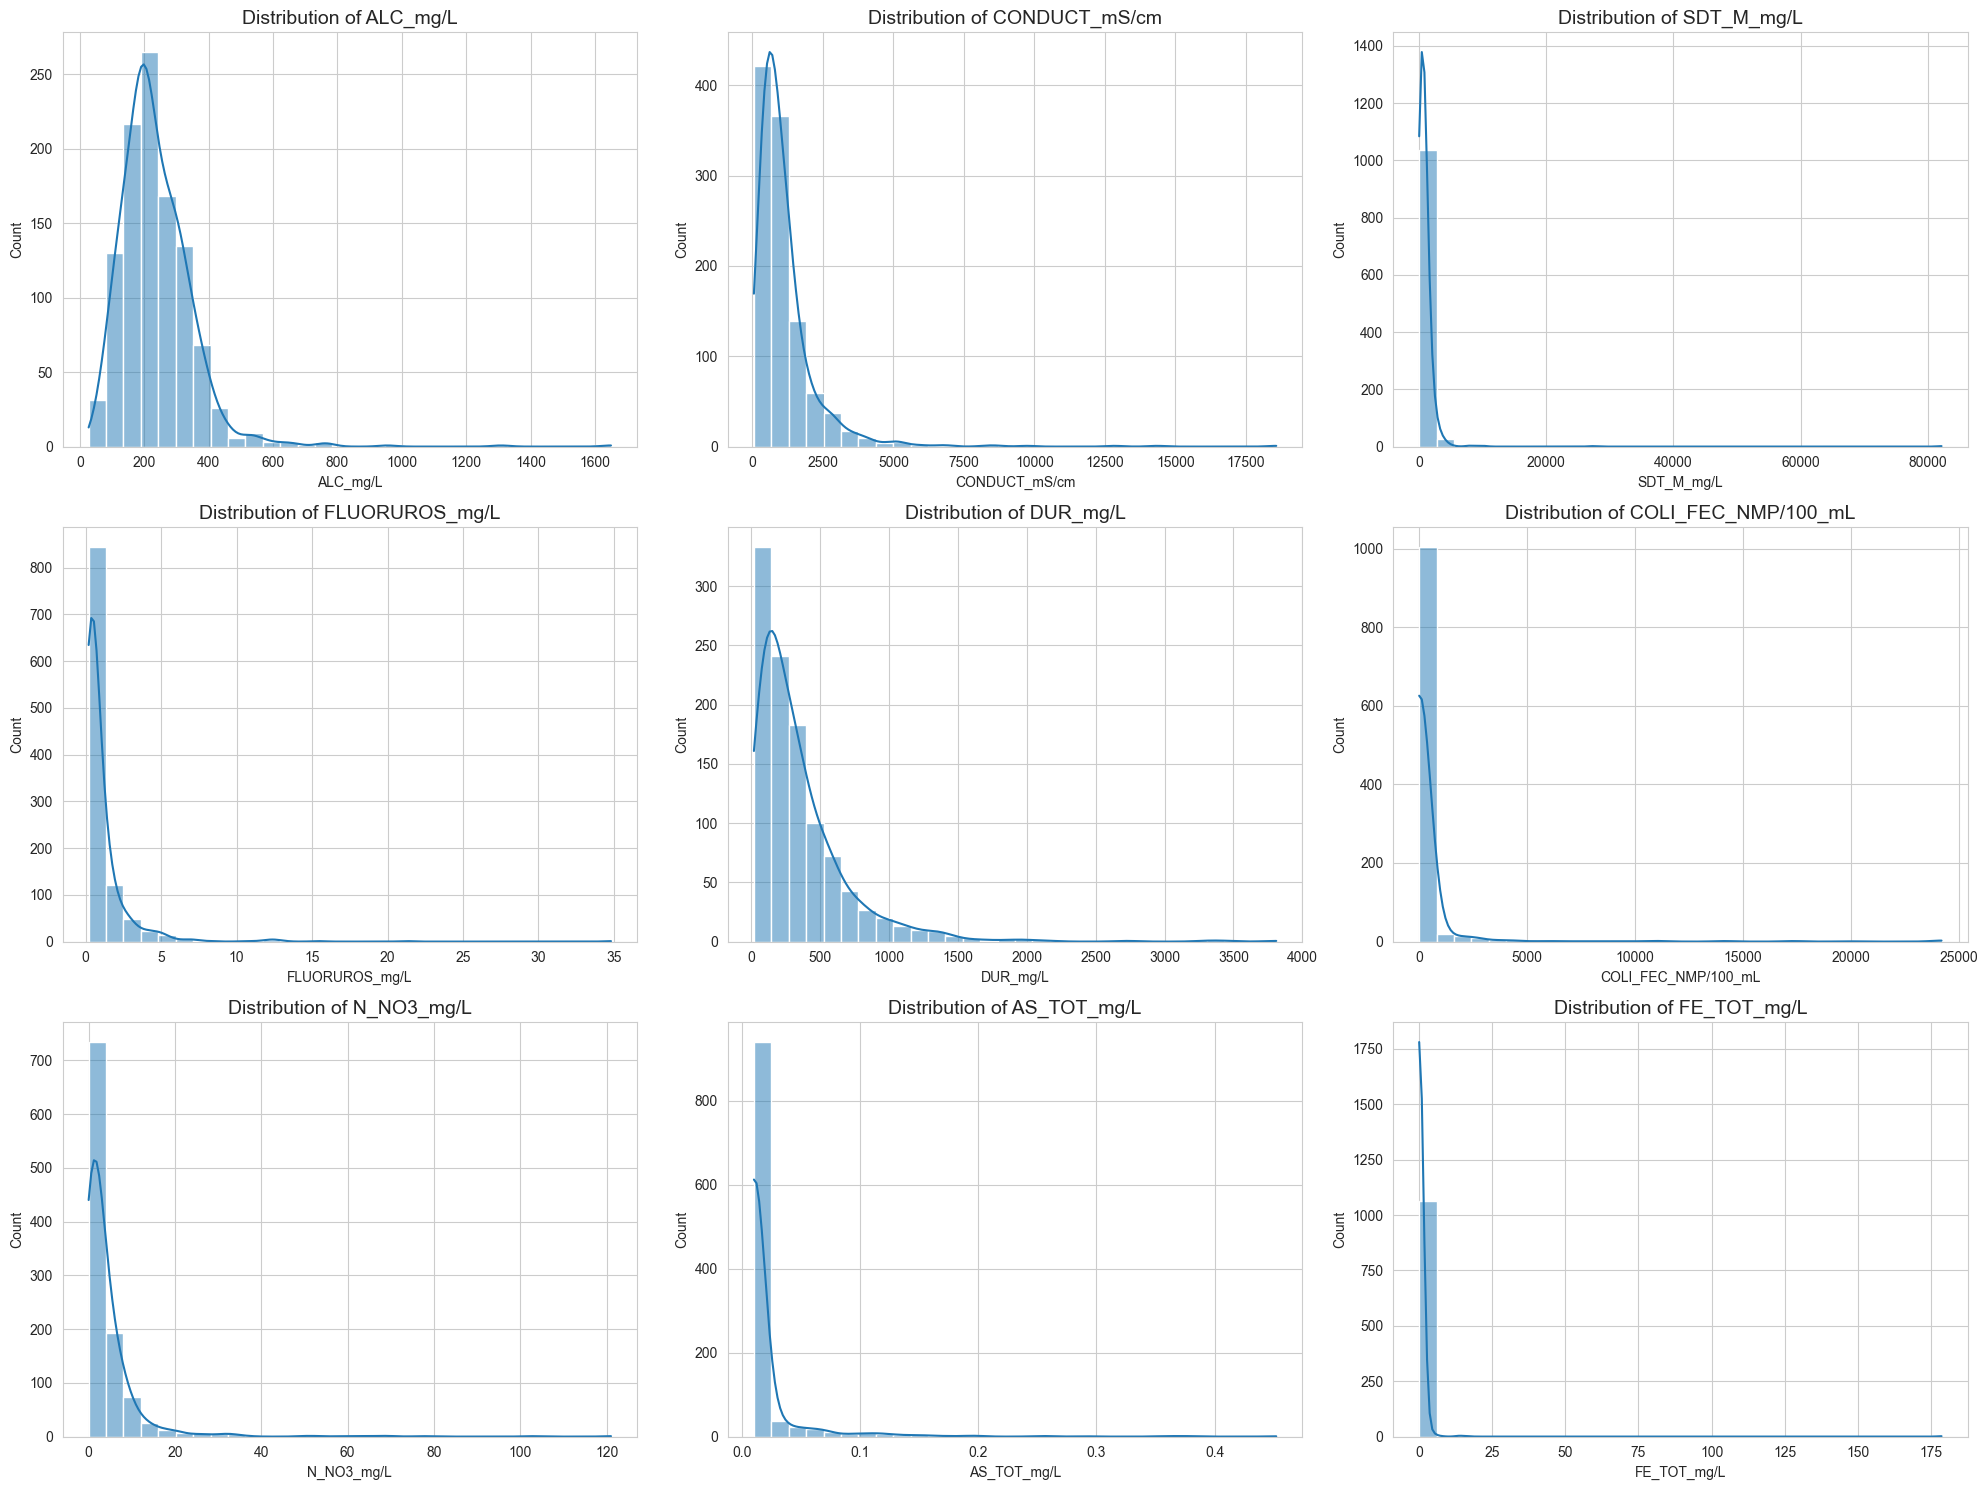


--- Visualizing Distributions of Key Categorical Variables ---


/var/folders/ln/1fq131xs4239j52l9_hprtb40000gn/T/ipykernel_948/2089256233.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SEMAFORO', data=df_cleaned, order=['Verde', 'Amarillo', 'Rojo'], palette=color_map, ax=axes[0])
/var/folders/ln/1fq131xs4239j52l9_hprtb40000gn/T/ipykernel_948/2089256233.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='ESTADO', data=df_cleaned, order=df_cleaned['ESTADO'].value_counts().index, palette='crest', ax=axes[1])


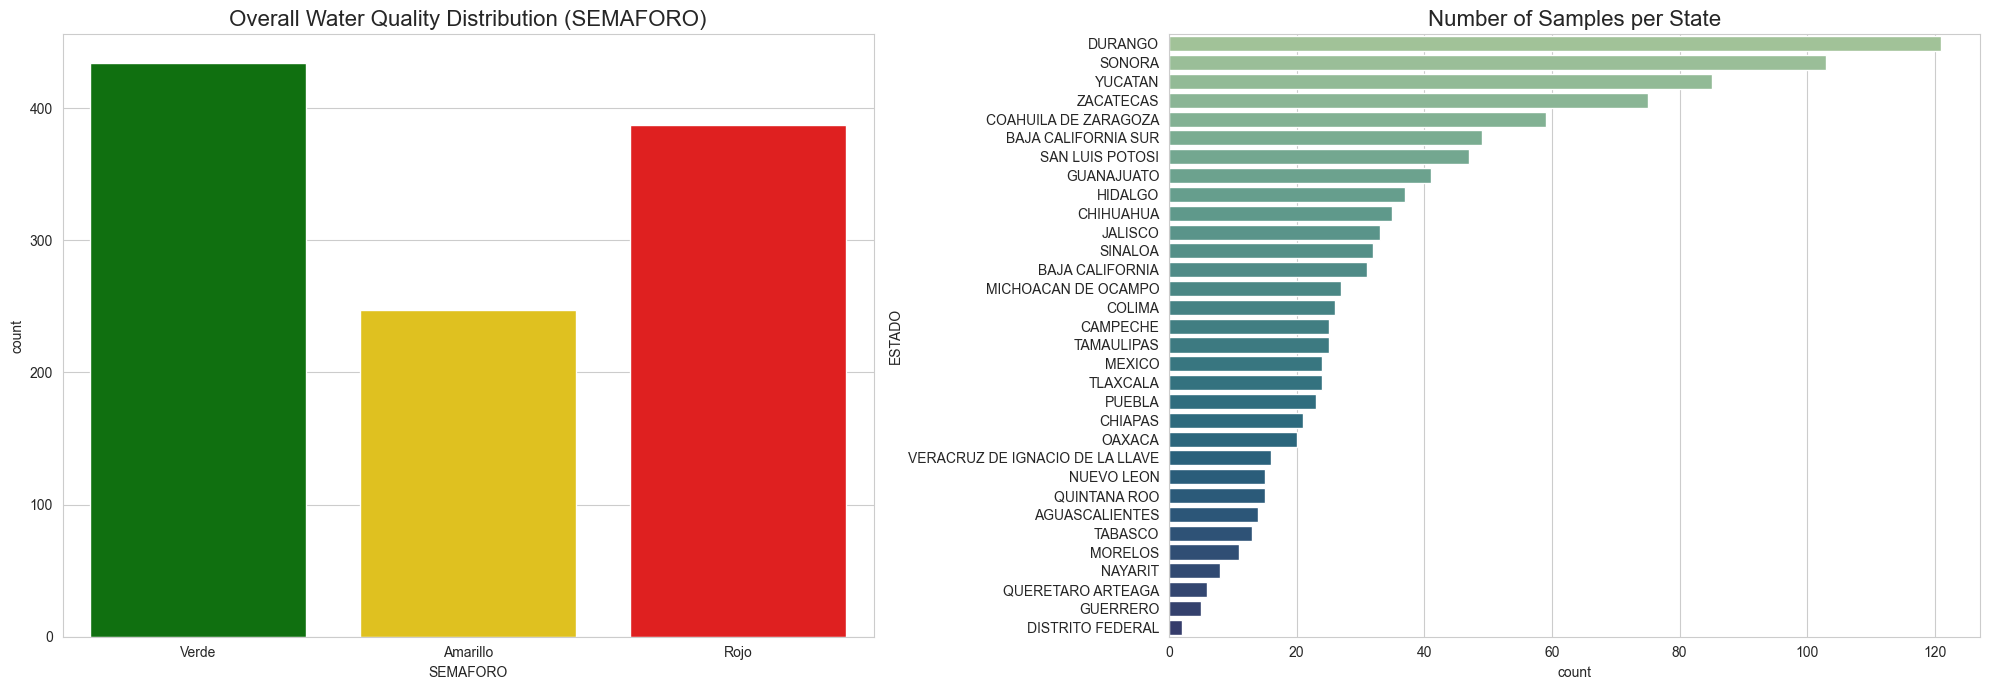

In [124]:
if 'df_cleaned' in locals() and df_cleaned is not None:
    # --- Distributions of Key Numerical Variables ---
    print("--- Visualizing Distributions of Key Numerical Variables ---")
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    cols_to_plot = ['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 
                    'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'FE_TOT_mg/L']
    
    for i, col in enumerate(cols_to_plot):
        if col in df_cleaned.columns:
            ax = axes.flatten()[i]
            sns.histplot(df_cleaned[col], kde=True, ax=ax, bins=30)
            ax.set_title(f'Distribution of {col}', fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Distributions of Key Categorical Variables ---
    print("\n--- Visualizing Distributions of Key Categorical Variables ---")
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    color_map = {'Verde': 'green', 'Amarillo': 'gold', 'Rojo': 'red'}
    sns.countplot(x='SEMAFORO', data=df_cleaned, order=['Verde', 'Amarillo', 'Rojo'], palette=color_map, ax=axes[0])
    axes[0].set_title('Overall Water Quality Distribution (SEMAFORO)', fontsize=16)

    sns.countplot(y='ESTADO', data=df_cleaned, order=df_cleaned['ESTADO'].value_counts().index, palette='crest', ax=axes[1])
    axes[1].set_title('Number of Samples per State', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame 'df_cleaned' not found. Please ensure the previous steps ran correctly.")

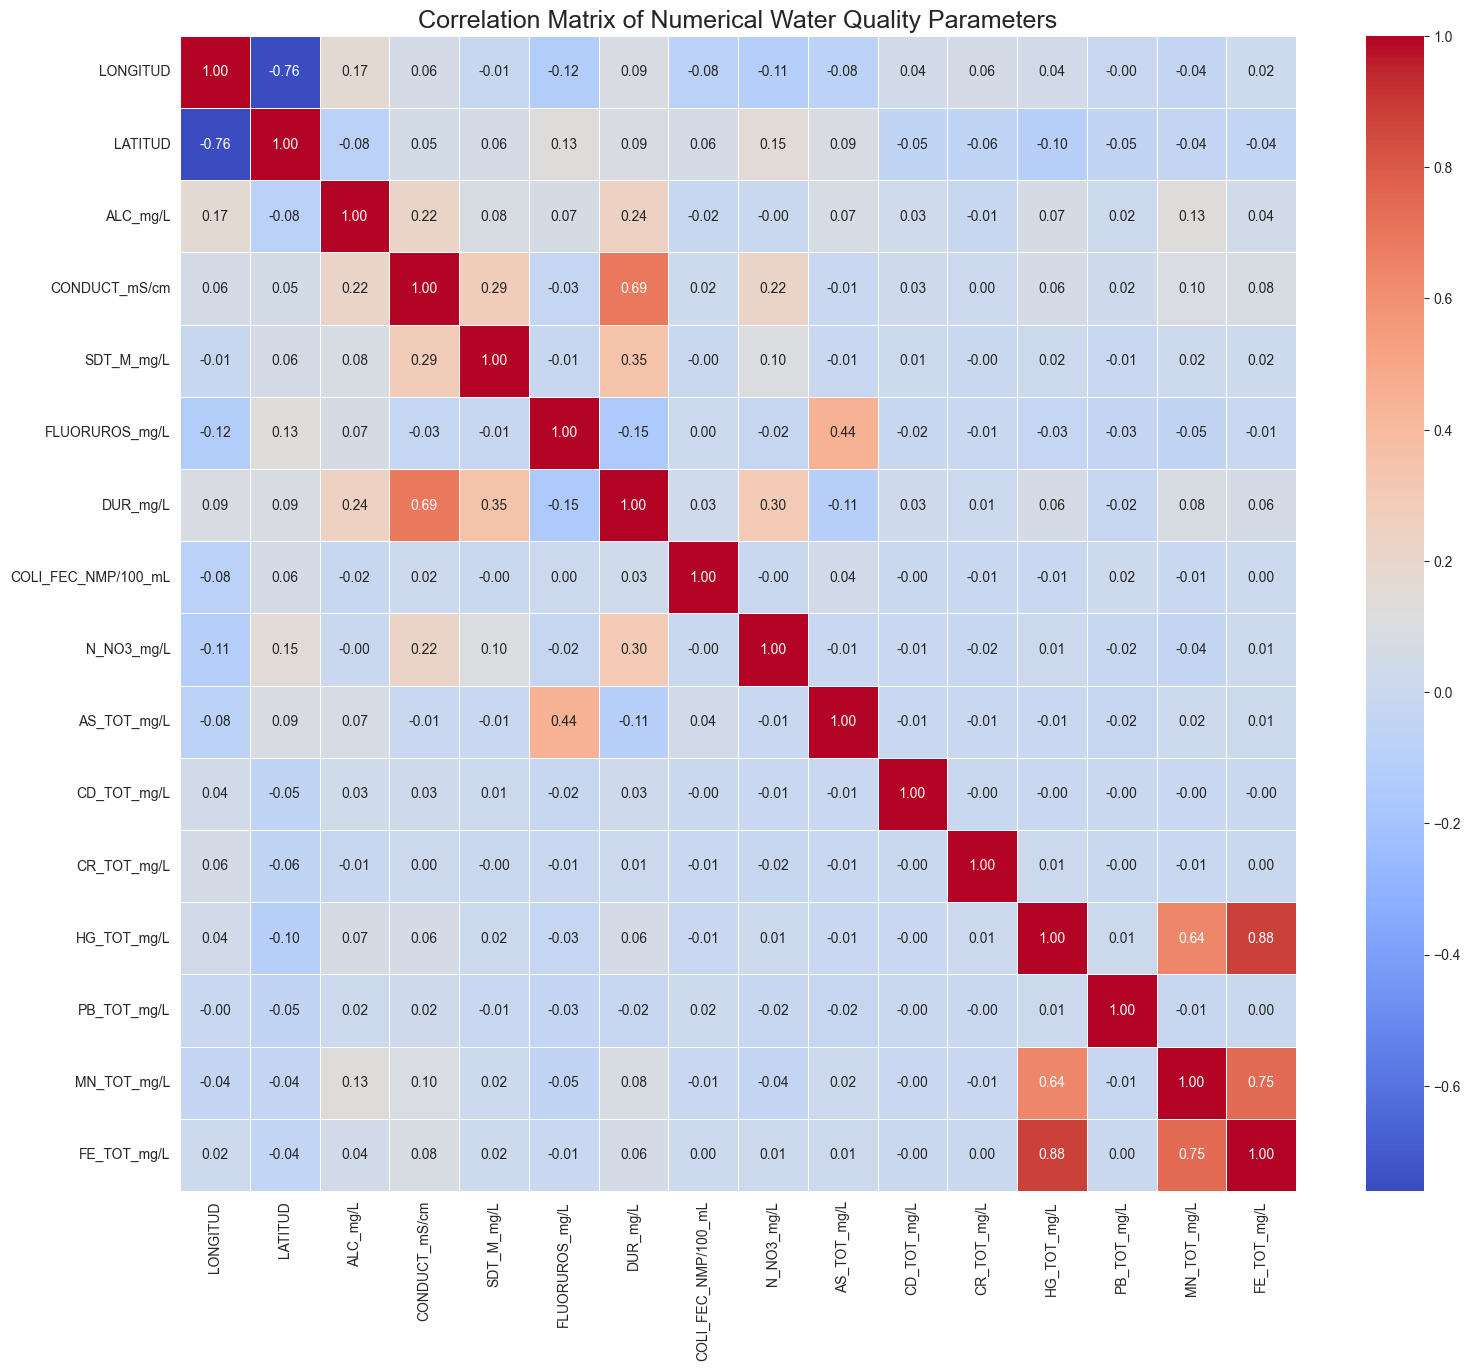

In [125]:
if 'df_cleaned' in locals() and df_cleaned is not None:
    # We need the list of numerical columns again for the correlation matrix
    numerical_cols = [
        'LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 
        'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 
        'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L',
        'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L'
    ]
    
    # Calculate the correlation matrix
    correlation_matrix = df_cleaned[numerical_cols].corr()

    # Plot the heatmap
    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix of Numerical Water Quality Parameters', fontsize=18)
    plt.show()
else:
    print("DataFrame 'df_cleaned' not found. Please ensure the previous steps ran correctly.")

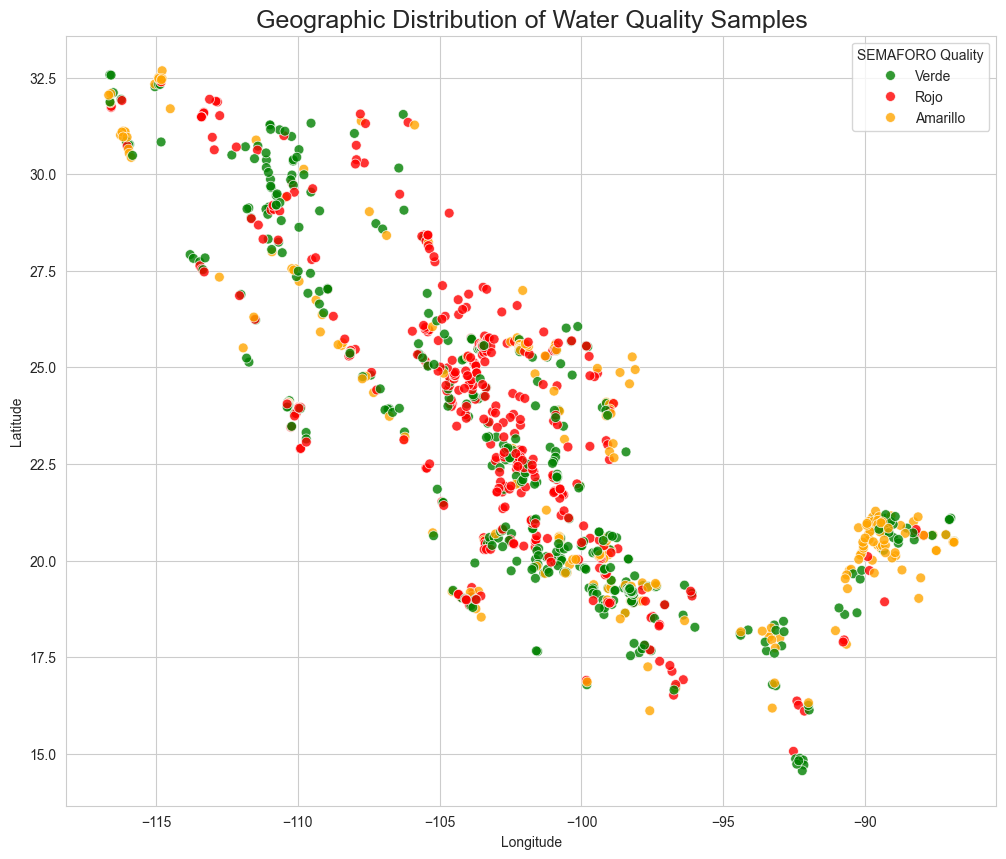

In [126]:
if 'df_cleaned' in locals() and df_cleaned is not None:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x='LONGITUD', 
        y='LATITUD', 
        hue='SEMAFORO',
        palette={'Verde': 'green', 'Amarillo': 'orange', 'Rojo': 'red'},
        data=df_cleaned,
        alpha=0.8,
        s=50  # size of points
    )
    plt.title('Geographic Distribution of Water Quality Samples', fontsize=18)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(title='SEMAFORO Quality')
    plt.show()
else:
    print("DataFrame 'df_cleaned' not found. Please ensure the previous steps ran correctly.")

### Sección 5: Ingeniería de Características y Preparación Final del Modelo

#### Resumen Ejecutivo de la Sección

Esta sección representa la fase final del preprocesamiento de datos, donde se aplican las decisiones estratégicas derivadas del Análisis Exploratorio de Datos (EDA). El objetivo fue construir el conjunto de datos final, `X_scaled`, optimizado para el entrenamiento del modelo de clustering. El pipeline consistió en tres etapas clave: selección de características, transformación no lineal y escalado.

#### Metodología y Ejecución

1.  **Selección de Características:** Basado en los hallazgos del EDA, se seleccionó un subconjunto de 15 características informativas. Este conjunto incluye las mediciones fisicoquímicas y bacteriológicas, junto con las coordenadas geográficas (`LONGITUD`, `LATITUD`). Se excluyeron deliberadamente los identificadores, las etiquetas de calidad predefinidas y la variable redundante `SDT_M_mg/L` (debido a su alta colinealidad con `CONDUCT_mS/cm`).

2.  **Transformación No Lineal:** Para mitigar el fuerte sesgo positivo identificado en las variables de medición, se aplicó una **transformación logarítmica (`np.log1p`)**. Esta operación comprime el rango de las características, reduce el impacto de los valores atípicos y resulta en distribuciones más simétricas, lo cual es fundamental para algoritmos basados en distancia como K-Means. Las coordenadas geográficas fueron excluidas de esta transformación.

3.  **Escalado de Características:** Como paso final, se aplicó un escalado mediante `StandardScaler` a todas las características seleccionadas. Este proceso estandariza cada característica para que tenga una media de cero y una desviación estándar de uno. El escalado es crucial para asegurar que todas las variables contribuyan de manera equitativa al cálculo de distancias del modelo, evitando que aquellas con magnitudes naturalmente mayores dominen el proceso de clustering.

#### Conclusión de la Sección

La ejecución de esta celda ha sido exitosa, culminando en la creación de la matriz de características `X_scaled` con dimensiones `(1068, 15)`. Esta matriz representa el conjunto de datos final, completamente preprocesado y optimizado. Está lista para ser utilizada como entrada directa en la siguiente fase del proyecto: el entrenamiento y la evaluación de los modelos de clustering.

In [127]:
from sklearn.preprocessing import StandardScaler

if 'df_cleaned' in locals() and df_cleaned is not None:
    # --- 1. Feature Selection ---
    # We drop SDT_M_mg/L because of its high correlation with CONDUCT_mS/cm.
    features_for_clustering = [
        'LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm', 'FLUORUROS_mg/L', 
        'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 
        'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 
        'MN_TOT_mg/L', 'FE_TOT_mg/L'
    ]
    df_model = df_cleaned[features_for_clustering].copy()

    # --- 2. Data Transformation (Log Transform) ---
    # We do not transform Latitude and Longitude as they are not skewed in the same way.
    cols_to_transform = [col for col in features_for_clustering if col not in ['LONGITUD', 'LATITUD']]
    
    print("Applying Log Transformation to skewed features...")
    for col in cols_to_transform:
        df_model[col] = np.log1p(df_model[col])
    
    print("--- Data after Log Transformation (first 5 rows) ---")
    display(df_model.head())

    # --- 3. Scaling ---
    print("\nScaling all features using StandardScaler...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_model)
    
    print(f"\nShape of the final scaled data for clustering: {X_scaled.shape}")
    print("This data is now fully preprocessed and ready for clustering algorithms.")

else:
    print("DataFrame 'df_cleaned' not found. Please ensure the previous steps ran correctly.")

Applying Log Transformation to skewed features...
--- Data after Log Transformation (first 5 rows) ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,-102.02210,22.20887,5.442374,6.846943,0.681378,5.369391,0.741937,1.645703,0.015972,0.002996,0.004988,0.0005,0.004988,0.001499,0.085352
1,-102.20075,21.99958,5.450996,6.411818,0.657416,5.226023,0.741937,1.909559,0.013311,0.002996,0.004988,0.0005,0.004988,0.001499,0.024693
2,-102.28801,22.36685,5.327488,6.278521,1.031225,4.801715,0.741937,0.896008,0.036332,0.002996,0.004988,0.0005,0.004988,0.001499,0.024693
3,-102.29449,22.18435,5.793014,6.532334,0.752783,5.302703,0.741937,0.814744,0.015283,0.002996,0.004988,0.0005,0.004988,0.001499,0.024693
4,-110.24480,23.45138,5.739423,7.518607,0.210504,6.169584,5.676754,2.813746,0.009950,0.002996,0.004988,0.0005,0.004988,0.001499,0.024693



Scaling all features using StandardScaler...

Shape of the final scaled data for clustering: (1068, 15)
This data is now fully preprocessed and ready for clustering algorithms.


### Sección 6: Determinación del Número Óptimo de Clusters (k) y Entrenamiento del Modelo Final

#### Resumen Ejecutivo de la Sección

El objetivo de esta sección fue determinar el número óptimo de clusters, `k`, para el algoritmo K-Means y entrenar el modelo final. Se emplearon dos técnicas de diagnóstico (Método del Codo y Puntuación de Silueta) y se realizó un análisis de la distribución de las muestras para tomar una decisión informada y robusta.

#### Metodología y Ejecución

Se entrenaron modelos K-Means iterativamente para un rango de `k` de 2 a 15, evaluando la inercia y la Puntuación de Silueta para cada `k`. Adicionalmente, se entrenaron modelos exploratorios con los candidatos principales (`k=5` y `k=11`) para analizar la distribución del tamaño de los clusters resultantes.

#### Análisis de Resultados

1.  **Análisis del Método del Codo:** La gráfica de inercia mostró una pronunciada caída inicial que comenzó a aplanarse notablemente alrededor de **k=5 y k=6**. Esto sugiere que una solución con un número bajo de clusters amplios podría ser razonable.

2.  **Análisis de la Puntuación de Silueta:** Esta métrica cuantitativa proporcionó una guía más definitiva, alcanzando su **máximo global inequívoco en k=11** (score ≈ 0.182). Este pico indica que la mejor separabilidad matemática de los grupos se logra con una partición más granular.

3.  **Análisis de Tamaño de Clusters y Detección de Outliers:** Al entrenar modelos con `k=5` y `k=11`, se observó un patrón revelador:
    *   Con `k=5`, el modelo creó un **cluster "singleton"** (con un solo miembro), aislando el outlier más extremo del conjunto de datos.
    *   Con `k=11`, el modelo fue capaz de identificar y aislar **tres clusters singleton** y otro cluster muy pequeño (4 miembros).

    Este comportamiento confirma la presencia de múltiples outliers extremos en los datos. El valor de `k` más alto (11) permite al algoritmo aislar estas anomalías de manera más efectiva, lo que a su vez permite un análisis más claro de los patrones principales en el resto de los datos. Este fenómeno también explica por qué la Puntuación de Silueta (sensible a la buena separación) favoreció un `k` más alto.

#### Conclusión de la Sección y Decisión Final

Al sintetizar los tres análisis, se obtiene una visión completa. Mientras el Método del Codo sugiere una solución simple (k≈5-6), tanto la Puntuación de Silueta como el análisis de la distribución de clusters demuestran que una solución más granular (k=11) es superior. Esta última no solo es matemáticamente óptima, sino que también tiene la capacidad de **identificar y aislar eficazmente las muestras más anómalas** del conjunto de datos.

**Decisión:** Se seleccionará **k=11** como el número óptimo de clusters para el modelo final. Esta decisión se fundamenta en la evidencia cuantitativa de la Puntuáción de Silueta y se ve reforzada por la capacidad demostrada del modelo para gestionar y separar outliers, lo que permitirá una caracterización más precisa y detallada de los perfiles de calidad del agua.

Calculating inertia for a range of k values...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/p

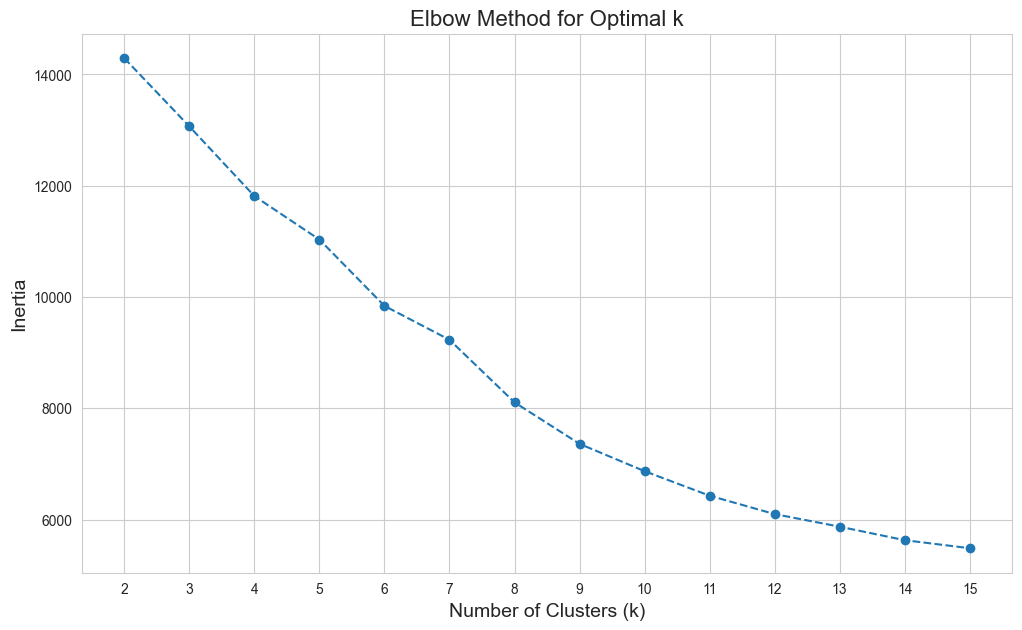

In [128]:
from sklearn.cluster import KMeans

# Ensure X_scaled is available from the previous steps
if 'X_scaled' in locals():
    inertia = []
    k_range = range(2, 16) # We will test k from 2 to 15 clusters

    print("Calculating inertia for a range of k values...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Plotting the Elbow Method results
    plt.figure(figsize=(12, 7))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Inertia', fontsize=14)
    plt.title('Elbow Method for Optimal k', fontsize=16)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
else:
    print("Error: The scaled dataset 'X_scaled' was not found. Please run the previous preprocessing steps.")

Calculating silhouette scores for a range of k values...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/p

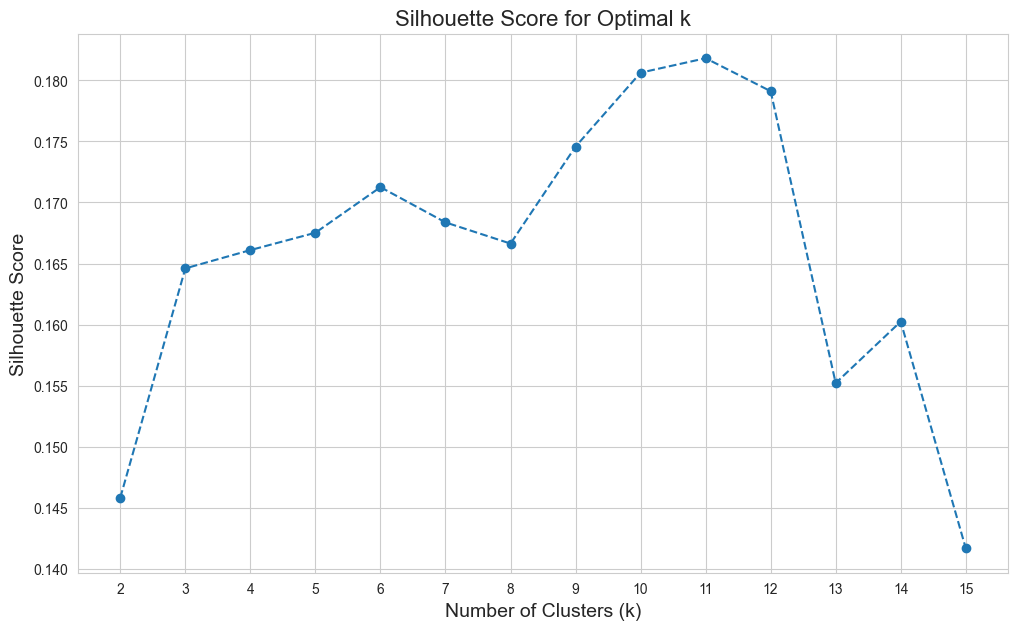

In [129]:
from sklearn.metrics import silhouette_score

if 'X_scaled' in locals():
    silhouette_scores = []
    k_range = range(2, 16)

    print("Calculating silhouette scores for a range of k values...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

    # Plotting the Silhouette Scores
    plt.figure(figsize=(12, 7))
    plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.title('Silhouette Score for Optimal k', fontsize=16)
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
else:
    print("Error: The scaled dataset 'X_scaled' was not found.")

In [130]:
# --- IMPORTANT ---
# Based on your analysis of the plots above, choose the best k for your data.
optimal_k = 5
# -----------------

if 'X_scaled' in locals() and 'df_cleaned' in locals():
    # Train the final model with the chosen number of clusters
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_final.fit(X_scaled)

    # Add the cluster labels to our main cleaned DataFrame for easy analysis
    df_cleaned['cluster'] = kmeans_final.labels_

    print(f"Successfully trained K-Means model with {optimal_k} clusters.")
    print("\nNumber of samples in each cluster:")
    print(df_cleaned['cluster'].value_counts().sort_index())
    
    # Display the first few rows with the new 'cluster' column
    display(df_cleaned.head())
else:
    print("Error: Required data ('X_scaled' or 'df_cleaned') not found. Please run previous steps.")

Successfully trained K-Means model with 5 clusters.

Number of samples in each cluster:
cluster
0     51
1    321
2    309
3    386
4      1
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/p

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,cluster
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,2
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,3
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,3
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,2
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,NO,SI,SI,SI,SI,SI,SI,SI,1


In [131]:
# --- IMPORTANT ---
# Based on your analysis of the plots above, choose the best k for your data.
optimal_k = 11
# -----------------

if 'X_scaled' in locals() and 'df_cleaned' in locals():
    # Train the final model with the chosen number of clusters
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    kmeans_final.fit(X_scaled)

    # Add the cluster labels to our main cleaned DataFrame for easy analysis
    df_cleaned['cluster'] = kmeans_final.labels_

    print(f"Successfully trained K-Means model with {optimal_k} clusters.")
    print("\nNumber of samples in each cluster:")
    print(df_cleaned['cluster'].value_counts().sort_index())
    
    # Display the first few rows with the new 'cluster' column
    display(df_cleaned.head())
else:
    print("Error: Required data ('X_scaled' or 'df_cleaned') not found. Please run previous steps.")

Successfully trained K-Means model with 11 clusters.

Number of samples in each cluster:
cluster
0      45
1     122
2     234
3       1
4       4
5       1
6       1
7     174
8     193
9     273
10     20
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.12/lib/p

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,cluster
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,2
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,2
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,7
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,7
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,NO,SI,SI,SI,SI,SI,SI,SI,1


### Sección 7.1: Análisis e Interpretación de Perfiles de Cluster

#### Resumen Ejecutivo de la Sección

Tras el entrenamiento exitoso del modelo K-Means con k=11, esta sección se centra en la fase más crítica del análisis: la **interpretación y caracterización de los clusters resultantes**. El objetivo fue traducir los centroides numéricos abstractos del modelo en perfiles descriptivos y accionables, utilizando las reglas de negocio para dar significado a cada grupo.

#### Metodología y Ejecución

1.  **Extracción y Retro-transformación de Centroides:** Se extrajeron los centroides de cada uno de los 11 clusters del objeto `kmeans_final`. Estos centroides, que existen en un espacio de datos transformado y escalado, fueron sometidos a un proceso inverso (des-escalado y transformación exponencial) para devolverlos a su escala original e interpretable (ej. mg/L).

2.  **Generación de Perfiles Descriptivos:** Se iteró sobre los valores de los centroides en su escala original. Cada valor fue procesado por la función `get_quality_label_from_value` para asignarle su etiqueta de calidad categórica correspondiente.

3.  **Consolidación:** Los resultados se consolidaron en la tabla `Descriptive Cluster Profiles`, que muestra las características cualitativas y el tamaño de cada cluster.

#### Análisis de Resultados y Caracterización Detallada de Clusters

El análisis de los perfiles reveló una estructura de datos rica y compleja, permitiendo la identificación de patrones principales y la aislación de anomalías extremas. A continuación se presenta el desglose y la identidad asignada a cada uno de los 11 clusters:

---

**A) Clusters de Patrones Principales:**
*Estos grupos representan los perfiles de agua más comunes y recurrentes en el conjunto de datos.*

-   **Cluster 9 (n=273): "Agua Dura de Buena Calidad General"**
    -   **Perfil:** El grupo más grande. Su agua es dura y permisible para riego. Es `Potable - Excelente` en casi todos los metales pesados y contaminantes.
    -   **Identidad:** Representa el perfil de agua "base" más común: dura por su origen geológico pero limpia de contaminación significativa. Geográficamente dominante en la Península de Yucatán.

-   **Cluster 2 (n=234): "Agua Dura con Ligera Presencia de Arsénico"**
    -   **Perfil:** Muy similar al Cluster 9, pero el Arsénico (`AS`) se encuentra en niveles de `Apta como FAAP`, indicando una presencia leve pero medible.
    -   **Identidad:** Una gran población de pozos que, aunque generalmente buenos, requieren monitoreo por sus niveles incipientes de arsénico.

-   **Cluster 8 (n=193): "Agua Suave de Buena Calidad"**
    -   **Perfil:** Agua `Moderadamente suave` y `Buena para riego`. Es excelente en la mayoría de parámetros, con solo una ligera presencia de arsénico (`Apta como FAAP`).
    -   **Identidad:** El perfil de agua de mayor calidad general, ideal para múltiples usos. Concentrado en el noroeste de México.

-   **Cluster 7 (n=174): "Agua Suave con Contaminación Geológica (Flúor y Arsénico)"**
    -   **Perfil:** A pesar de ser `Moderadamente suave`, presenta niveles de Flúor (`FLUO`) en categoría `Alta` y de Arsénico (`AS`) como `No apta como FAAP`.
    -   **Identidad:** Un perfil de contaminación natural muy definido. El agua no es dura, pero estos contaminantes la hacen no apta para consumo sin tratamiento.

-   **Cluster 1 (n=122): "Agua Dura con Indicios de Contaminación Múltiple (As y Cd)"**
    -   **Perfil:** Agua dura donde tanto el Arsénico (`AS`) como el Cadmio (`CD`) se clasifican como `Apta como FAAP`.
    -   **Identidad:** Un perfil que sugiere una posible fuente de contaminación más compleja al presentar indicios de múltiples metales.

-   **Cluster 0 (n=45): "Agua Dura con Minerales Secundarios (Mn y Fe)"**
    -   **Perfil:** Agua dura, limpia de metales pesados tóxicos, pero con problemas de Manganeso (`MN` - `Puede afectar la salud`) y Hierro (`FE` - `Puede dar color al agua`).
    -   **Identidad:** Un perfil con problemas de calidad "secundarios", comunes en aguas subterráneas con alta carga mineral.

-   **Cluster 10 (n=20): "Agua Blanda de Alto Riesgo (Flúor y Arsénico)"**
    -   **Perfil:** Aunque es `Potable - Suave`, es de alta prioridad. Tanto el Flúor (`FLUO`) como el Arsénico (`AS`) están en sus peores categorías.
    -   **Identidad:** Un grupo pequeño pero crítico de pozos con fuerte contaminación natural, representando un riesgo para la salud.

-   **Cluster 4 (n=4): "Agua Dura con Contaminación por Plomo"**
    -   **Perfil:** Un grupo muy pequeño y específico cuyo problema principal es la contaminación por Plomo (`PB`), clasificado como `No apta como FAAP`.
    -   **Identidad:** Un perfil de alta prioridad que podría indicar contaminación industrial o de infraestructura antigua.

---

**B) Clusters de Anomalías (Outliers Extremos):**
*El modelo aisló exitosamente tres muestras únicas, cada una en su propio cluster "singleton".*

-   **Cluster 3 (n=1): "Anomalía por Dureza Extrema y Cadmio"**
    -   **Identidad:** El pozo con el agua más dura/salina que además presenta un problema de contaminación por Cadmio.

-   **Cluster 6 (n=1): "Anomalía por Cromo"**
    -   **Identidad:** La única muestra de todo el dataset con una clara y aislada señal de contaminación por Cromo.

-   **Cluster 5 (n=1): "Anomalía por Salinidad Extrema y Mercurio"**
    -   **Identidad:** Probablemente el pozo más contaminado del conjunto de datos, con una combinación única de salinidad en la peor categoría y la única señal significativa de contaminación por Mercurio.

---

#### Conclusión de la Sección

La interpretación de los centroides ha sido un éxito. Se ha logrado transformar la salida matemática del algoritmo K-Means en **11 perfiles de calidad del agua distintos, comprensibles y accionables**. Este análisis no solo valida la elección de k=11, sino que también proporciona una segmentación detallada del conjunto de datos, destacando tanto los patrones generales como las anomalías críticas que requieren atención inmediata.

In [132]:
if 'kmeans_final' in locals() and 'scaler' in locals() and 'df_model' in locals():
    # 1. Get the centroids (they are in the scaled space)
    centroids_scaled = kmeans_final.cluster_centers_

    # 2. Reverse the scaling
    centroids_log = scaler.inverse_transform(centroids_scaled)

    # 3. Reverse the log transformation (np.expm1 is the inverse of np.log1p)
    # *** THIS IS THE CORRECTED LINE ***
    # The columns of df_model are already the correct features, no need to drop anything.
    centroids_original_scale = pd.DataFrame(np.expm1(centroids_log), columns=df_model.columns)
    
    # 4. Build the descriptive profile for each cluster
    cluster_profiles = pd.DataFrame(index=centroids_original_scale.index)
    
    # We iterate over the columns of the centroids dataframe now
    for col in centroids_original_scale.columns:
        if col in ['LONGITUD', 'LATITUD']:
            continue # Skip quality labels for coordinates

        param_key = column_to_param_map.get(col)
        
        # Handle the special cases for SDT
        if col == 'SDT_M_mg/L': # This was dropped, but let's keep the logic just in case
            cluster_profiles['CALIDAD_SDT_salin'] = centroids_original_scale[col].apply(
                lambda x: get_quality_label_from_value('SDT_salin', x, quality_rules))
            cluster_profiles['CALIDAD_SDT_ra'] = centroids_original_scale[col].apply(
                lambda x: get_quality_label_from_value('SDT_ra', x, quality_rules))
        elif param_key:
            quality_col_name = f'CALIDAD_{param_key}'
            cluster_profiles[quality_col_name] = centroids_original_scale[col].apply(
                lambda x: get_quality_label_from_value(param_key, x, quality_rules))

    # Add the cluster size to the profile
    cluster_profiles['Cluster_Size'] = df_cleaned['cluster'].value_counts().sort_index()
    
    print("\n--- Cluster Centroids (Original Scale) ---")
    display(centroids_original_scale)

    print("\n--- Descriptive Cluster Profiles ---")
    # Transposing the DataFrame (.T) makes it easier to read when there are many features
    display(cluster_profiles.T)
else:
    print("Error: Required variables not found. Please run the previous sections.")


--- Cluster Centroids (Original Scale) ---


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
0,-1.0,6.030949e+09,293.572786,1180.172353,0.458814,365.635535,9.496941,0.635437,0.017735,0.003000,0.010781,0.000522,0.005255,0.908289,1.205803
1,-1.0,3.339606e+10,229.055287,1162.216982,0.583615,369.996624,665.190019,4.677934,0.014330,0.003021,0.005407,0.000515,0.005068,0.024618,0.186947
2,-1.0,7.193594e+11,208.121115,1100.267360,0.633701,357.102106,2.414911,4.717759,0.015173,0.003000,0.006708,0.000521,0.005000,0.022030,0.068618
3,-1.0,1.281389e+07,367.680000,2388.000000,0.200000,655.240000,1.100000,2.078600,0.010000,0.032110,0.005000,0.000500,0.005000,0.009870,0.223500
4,-1.0,5.893112e+09,222.789342,991.769615,0.290831,185.088462,305.398034,2.153444,0.010000,0.003000,0.005000,0.000500,0.053831,0.024443,0.513175
5,-1.0,9.253708e+07,356.000000,3891.000000,0.652000,888.000000,1.100000,8.576000,0.010000,0.003000,0.005000,0.014150,0.005000,8.982000,178.615000
6,-1.0,5.895470e+07,187.180000,1414.000000,0.856400,479.580000,1.100000,1.251300,0.010000,0.003000,5.003200,0.000500,0.005000,0.005190,0.490370
7,-1.0,3.819450e+10,205.701820,578.710315,2.545074,85.819120,3.216924,1.720229,0.027606,0.003000,0.005903,0.000525,0.005000,0.005254,0.066934
8,-1.0,1.170944e+09,129.365307,354.998369,0.425060,101.217177,3.270749,1.210316,0.012739,0.003000,0.010242,0.000527,0.005057,0.023799,0.122209
9,-1.0,5.519494e+08,283.167792,1232.999912,0.474415,419.805235,2.364367,1.885738,0.010992,0.003000,0.011086,0.000610,0.005271,0.020215,0.172915



--- Descriptive Cluster Profiles ---


,0,1,2,3,4,5,6,7,8,9,10
CALIDAD_ALC,Alta,Alta,Alta,Alta,Alta,Alta,Alta,Alta,Media,Alta,Alta
CALIDAD_CONDUC,Permisible para riego,Permisible para riego,Permisible para riego,Dudosa para riego,Permisible para riego,Indeseable para riego,Permisible para riego,Buena para riego,Buena para riego,Permisible para riego,Permisible para riego
CALIDAD_FLUO,Media,Media,Media,Baja,Baja,Media,Potable - Optima,Alta,Media,Media,Alta
CALIDAD_DUR,Potable - Dura,Potable - Dura,Potable - Dura,Muy dura e indeseable usos industrial y domestico,Potable - Dura,Muy dura e indeseable usos industrial y domestico,Potable - Dura,Potable - Moderadamente suave,Potable - Moderadamente suave,Potable - Dura,Potable - Suave
CALIDAD_COLI_FEC,No matching rule,Aceptable,No matching rule,No matching rule,Aceptable,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule
CALIDAD_N_NO3,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule,No matching rule
CALIDAD_AS,Apta como FAAP,Apta como FAAP,Apta como FAAP,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,No apta como FAAP,Apta como FAAP,Apta como FAAP,No apta como FAAP
CALIDAD_CD,Potable - Excelente,Apta como FAAP,Potable - Excelente,No apta como FAAP,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
CALIDAD_CR,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,No apta como FAAP,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente
CALIDAD_HG,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,No apta como FAAP,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente,Potable - Excelente


### Sección 7.2: Visualización de las Características de los Clusters

#### Resumen Ejecutivo de la Sección

Para validar y profundizar en la interpretación de los perfiles de cluster definidos en la sección anterior, se generaron visualizaciones comparativas. Se utilizaron diagramas de caja y bigotes (box plots) para analizar la distribución de las variables fisicoquímicas más relevantes a través de los 11 clusters identificados.

#### Metodología y Ejecución

Se seleccionó un subconjunto de características clave (`CONDUCT_mS/cm`, `DUR_mg/L`, `FLUORUROS_mg/L`, etc.) para la visualización. Para cada característica, se generó un diagrama de caja que compara su distribución entre los 11 clusters. De manera notable, se aplicó una **escala logarítmica** al eje Y para aquellas variables con un alto sesgo, una técnica que mejora drásticamente la legibilidad y la capacidad de comparación de los gráficos al controlar el efecto visual de los valores atípicos extremos.

#### Análisis de Resultados

Las visualizaciones proporcionan una confirmación empírica y contundente de las identidades de los clusters previamente definidas:

1.  **Validación de Perfiles de Contaminación:** Los gráficos para `FLUORUROS_mg/L` y `AS_TOT_mg/L` muestran de forma inequívoca que los clusters **7 y 10** tienen distribuciones de valores significativamente más altas que el resto, validando su caracterización como grupos de "Alta Contaminación por Flúor y Arsénico".

2.  **Validación de Perfiles Físicos:** El gráfico de `DUR_mg/L` ilustra una clara separación entre dos macro-grupos: clusters de "Agua Dura" (0, 1, 2, 4, 9) con valores de dureza elevados y clusters de "Agua Suave/Blanda" (7, 8, 10) con valores mucho más bajos.

3.  **Confirmación Visual de Outliers:** En los gráficos, los clusters singleton (3, 5, 6) aparecen como líneas horizontales únicas en lugar de cajas. Esto confirma visualmente su naturaleza de ser clusters con un solo miembro. La posición de estas líneas (ej. la línea extremadamente alta para el Cluster 5 en el gráfico de `CONDUCT_mS/cm`) ratifica su estatus como las muestras más anómalas del conjunto de datos.

#### Conclusión de la Sección

Los diagramas de caja han servido como una herramienta de validación visual indispensable. Han demostrado que las diferencias entre los centroides de los clusters no son solo promedios abstractos, sino que reflejan diferencias sistémicas y estadísticamente significativas en las distribuciones de los datos. Esta evidencia visual refuerza la confianza en la segmentación generada por el modelo K-Means y en la interpretación de los perfiles de cada cluster.

/var/folders/ln/1fq131xs4239j52l9_hprtb40000gn/T/ipykernel_948/259164038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df_cleaned, ax=ax, palette='viridis')
/var/folders/ln/1fq131xs4239j52l9_hprtb40000gn/T/ipykernel_948/259164038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df_cleaned, ax=ax, palette='viridis')
/var/folders/ln/1fq131xs4239j52l9_hprtb40000gn/T/ipykernel_948/259164038.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y=col, data=df_cleaned, ax=ax,

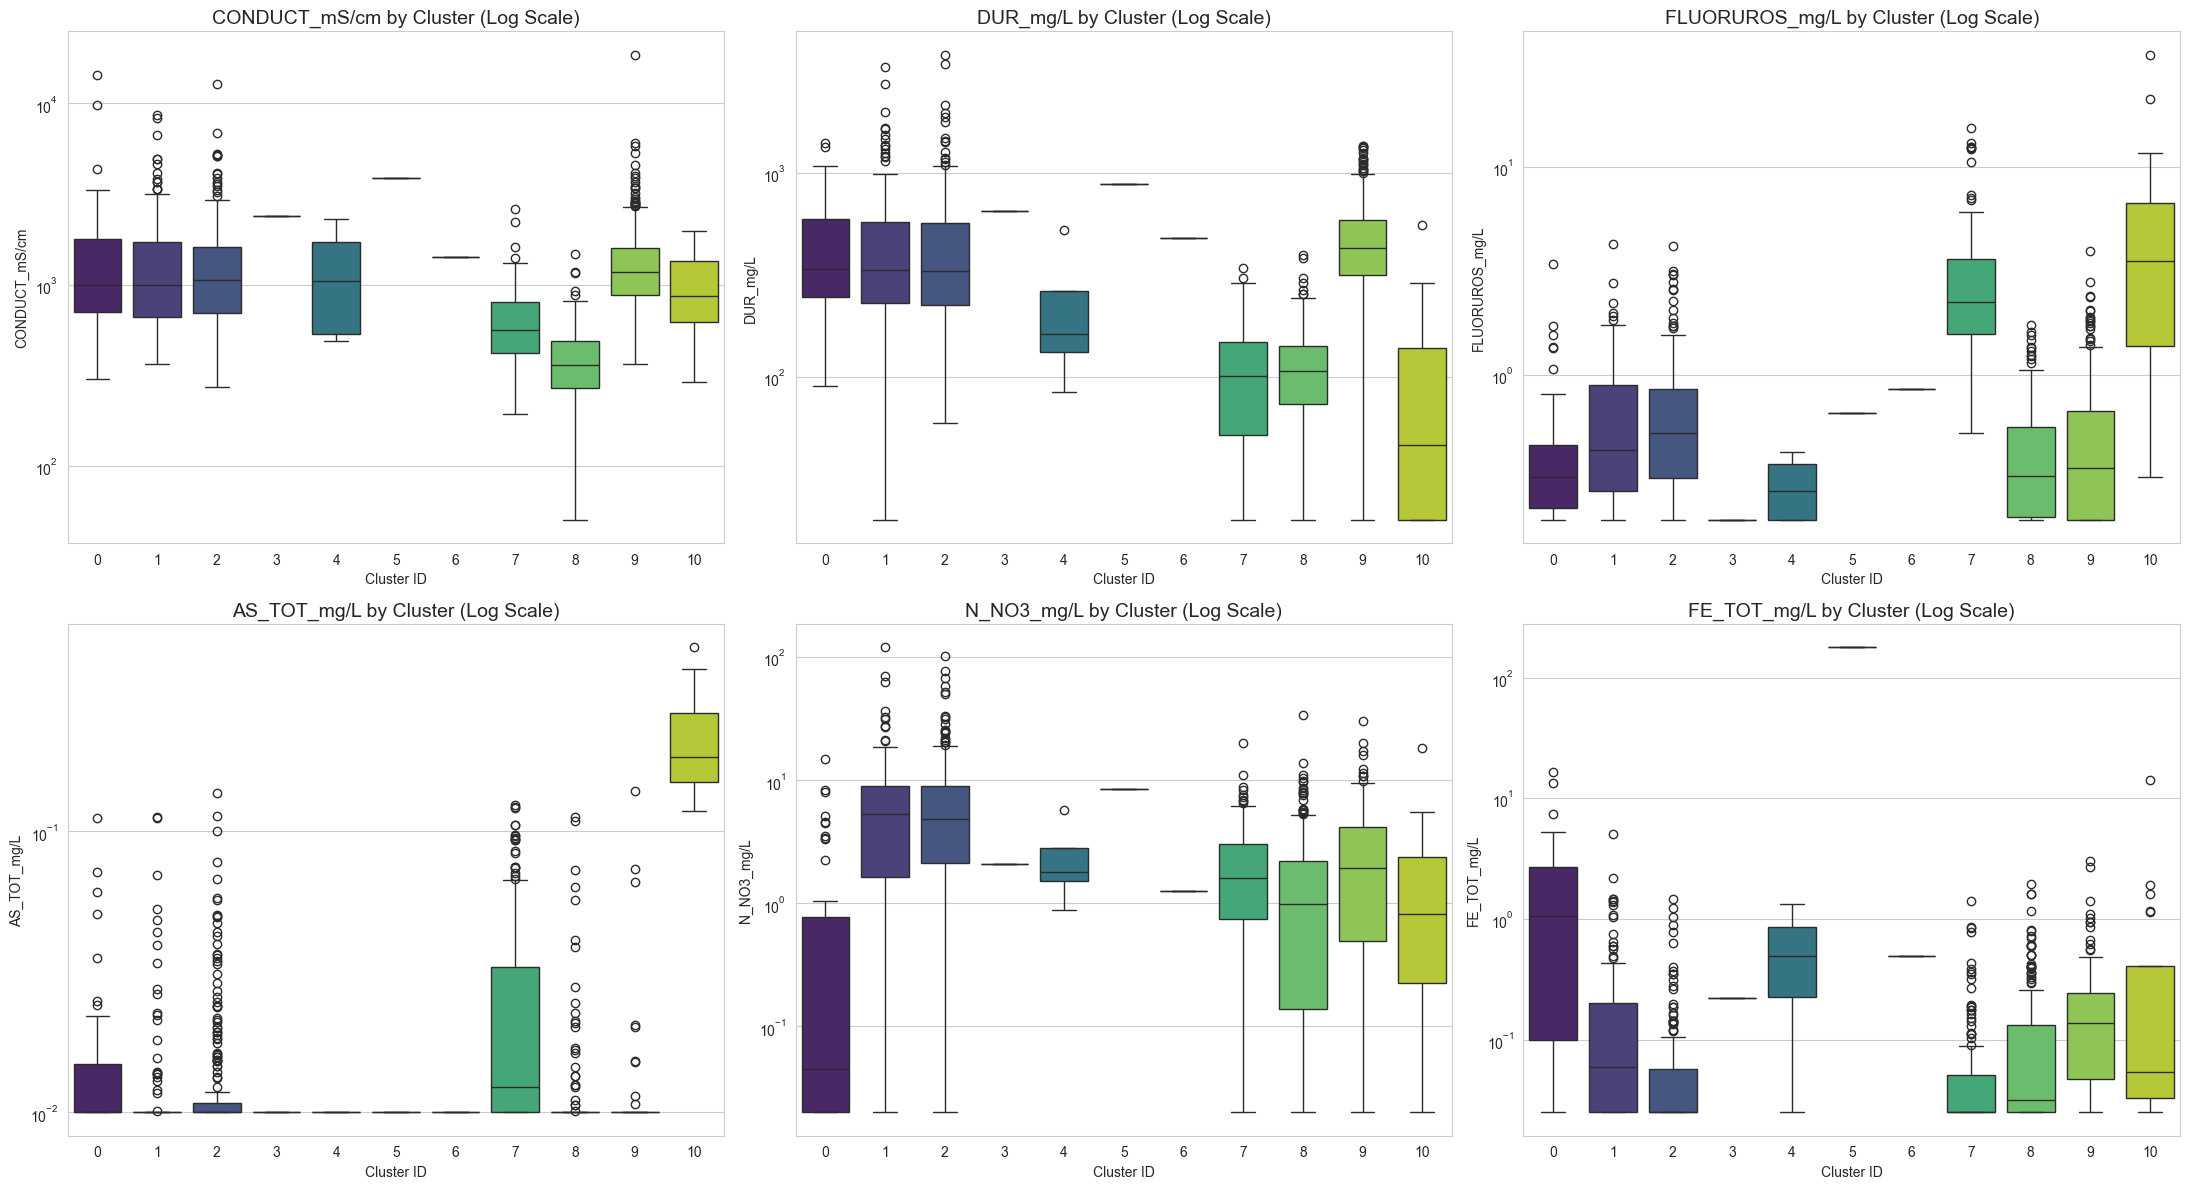

In [133]:
if 'df_cleaned' in locals():
    # Select a few key features to visualize
    cols_to_visualize = ['CONDUCT_mS/cm', 'DUR_mg/L', 'FLUORUROS_mg/L', 'AS_TOT_mg/L', 'N_NO3_mg/L', 'FE_TOT_mg/L']
    
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    axes = axes.flatten()

    for i, col in enumerate(cols_to_visualize):
        ax = axes[i]
        sns.boxplot(x='cluster', y=col, data=df_cleaned, ax=ax, palette='viridis')
        # Use a log scale for y-axis if the data is heavily skewed, makes plots more readable
        if df_cleaned[col].skew() > 3:
            ax.set_yscale('log')
            ax.set_title(f'{col} by Cluster (Log Scale)', fontsize=14)
        else:
            ax.set_title(f'{col} by Cluster', fontsize=14)
        ax.set_xlabel('Cluster ID')
    
    plt.tight_layout()
    plt.show()
else:
    print("Error: DataFrame 'df_cleaned' not found.")

### Sección 7.3: Visualización Geográfica de los Clusters

#### Resumen Ejecutivo de la Sección

La fase final del análisis consistió en visualizar la distribución espacial de los 11 clusters de calidad del agua identificados. El objetivo era determinar si los perfiles de cluster abstractos correspondían a regiones geográficas específicas, añadiendo una capa de contexto físico a los hallazgos del modelo.

#### Metodología y Ejecución

Se generó un mapa de dispersión (`scatterplot`) utilizando las coordenadas de `LONGITUD` y `LATITUD` de cada muestra. Cada punto en el mapa fue coloreado de acuerdo a la etiqueta de cluster (`cluster`) que le fue asignada por el modelo K-Means. Esto permite una inspección visual directa de la ubicación de cada perfil de calidad del agua.

#### Análisis de Resultados

La visualización geoespacial reveló patrones de distribución altamente estructurados y no aleatorios, lo que confirma que las características fisicoquímicas del agua están fuertemente ligadas a la ubicación geográfica. Los hallazgos más significativos son:

1.  **Coherencia Geológica Regional:** El modelo demostró una capacidad notable para agrupar muestras de regiones geológicas similares. El ejemplo más claro es el **Cluster 9 ("Agua Dura de Buena Calidad")**, que se encuentra casi exclusivamente en la **Península de Yucatán**, correspondiendo a su conocida geología kárstica.

2.  **Identificación de Zonas de Contaminación Natural:** Los clusters caracterizados por altos niveles de Flúor y Arsénico (principalmente **Cluster 7**) se concentran de manera predominante en las **regiones áridas y montañosas del norte y noroeste de México**. Esto alinea los hallazgos del modelo con el conocimiento experto sobre la presencia de estos contaminantes naturales en los acuíferos de dichas zonas.

3.  **Separación de Perfiles Intra-regionales:** Es de destacar que el modelo no solo agrupó por región, sino que fue capaz de diferenciar perfiles de calidad *dentro* de la misma región. Por ejemplo, en el noroeste, pudo separar las muestras de "Agua Suave Contaminada" (Cluster 7) de las de "Agua Suave de Buena Calidad" (Cluster 8), proporcionando una granularidad de análisis muy valiosa.

#### Conclusión de la Sección

La visualización geográfica valida de manera contundente la relevancia y el éxito del modelo de clustering. Demuestra que los clusters generados no son meras agrupaciones matemáticas, sino que representan **perfiles hidrogeológicos reales y geográficamente coherentes**.

Este mapa constituye una herramienta estratégica de alto valor, permitiendo a los gestores de recursos hídricos identificar rápidamente las "firmas" de calidad del agua de diferentes regiones, localizar zonas prioritarias para el monitoreo y el tratamiento, y comprender la extensión espacial de los problemas de contaminación.

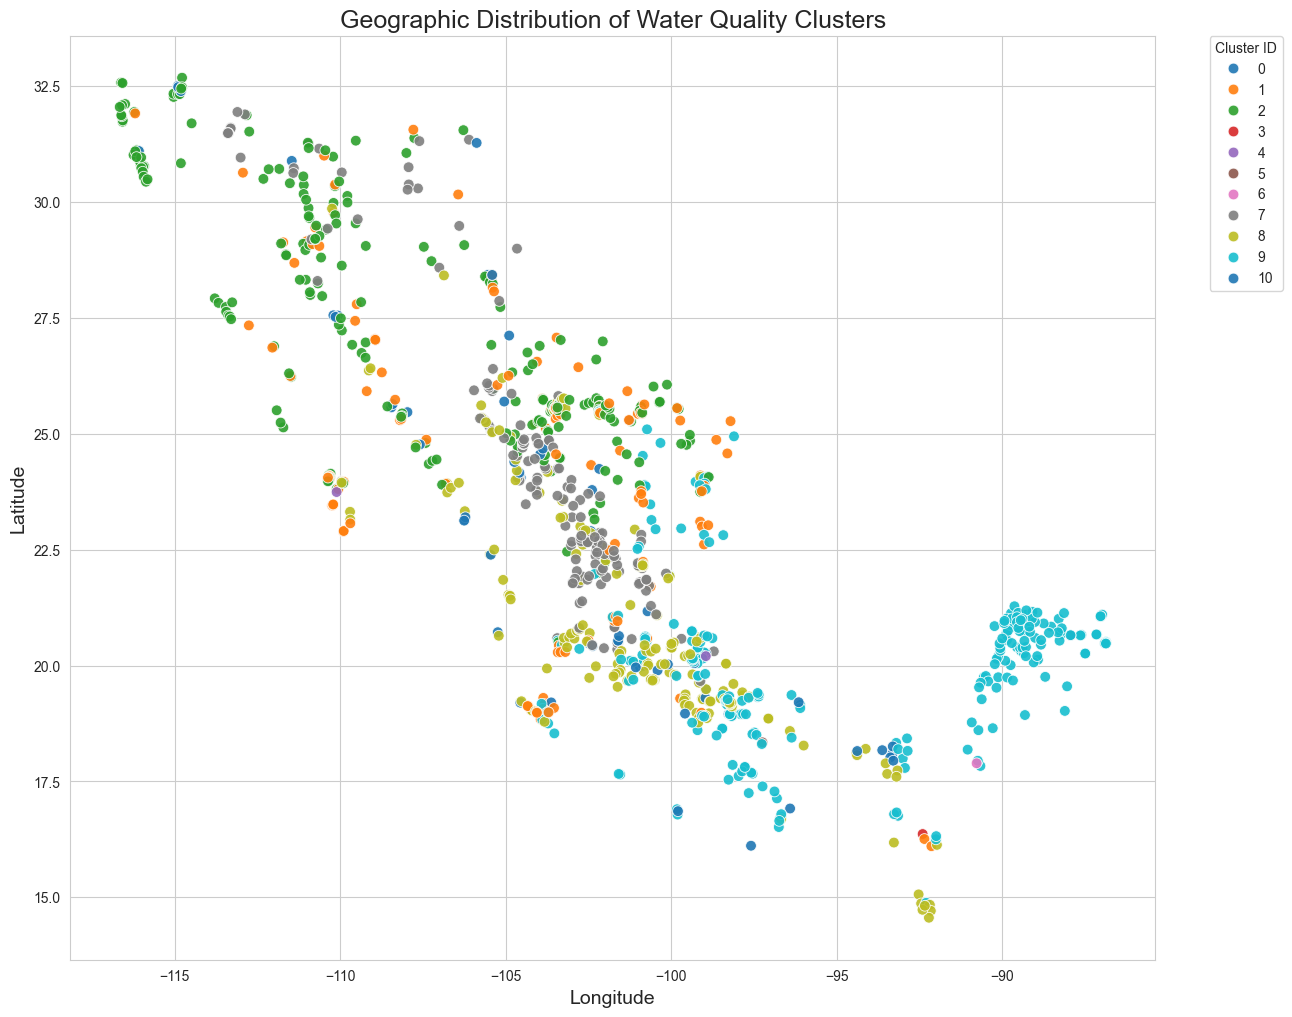

In [134]:
if 'df_cleaned' in locals():
    plt.figure(figsize=(14, 12))
    sns.scatterplot(
        x='LONGITUD', 
        y='LATITUD', 
        hue='cluster',
        palette='tab10', # A good palette for distinct categories
        data=df_cleaned,
        alpha=0.9,
        s=60,
        legend='full'
    )
    plt.title('Geographic Distribution of Water Quality Clusters', fontsize=18)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
else:
    print("Error: DataFrame 'df_cleaned' not found.")

# Análisis Exploratorio de Datos (EDA) y Modelado - Resumen Final de Hallazgos

A continuación, se presenta un resumen ejecutivo que responde a las preguntas clave del análisis, integrando los hallazgos desde la exploración inicial hasta la interpretación final del modelo de clustering.

### 1. ¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?

**Sí, se identificaron y gestionaron patrones de ausencia de manera robusta.**

-   **Eliminación y Ausencia Esperada:** La columna `SDT_mg/L` (100% vacía) fue eliminada, y la ausencia en `CONTAMINANTES` (43%) se confirmó como un patrón esperado para muestras de agua limpia.
-   **Imputación Inteligente:** Se detectó un patrón de ausencia correlacionada entre mediciones numéricas y sus etiquetas categóricas. En la **Sección 3**, se implementó una **imputación consistente**: los valores numéricos se rellenaron con la mediana, y sus etiquetas categóricas correspondientes se infirieron utilizando las reglas de negocio, garantizando la integridad lógica del dataset final.

### 2. ¿Cuáles son las estadísticas resumidas del conjunto de datos?

Las estadísticas descriptivas de la **Sección 4.1** fueron fundamentales para la estrategia de preprocesamiento, revelando:

-   **Disparidad de Escalas:** Una enorme diferencia en las escalas de las variables (ej. `CONDUCT_mS/cm` en miles vs. `HG_TOT_mg/L` en sub-milésimas), lo que hizo **indispensable el escalado de datos** realizado en la **Sección 5**.
-   **Alta Variabilidad y Presencia de Outliers:** Las altas desviaciones estándar y los valores máximos desproporcionados confirmaron una gran dispersión en los datos y la presencia de valores atípicos extremos, que fueron posteriormente gestionados.

### 3. ¿Hay valores atípicos en el conjunto de datos?

**Sí, y su identificación fue un resultado clave del análisis.**

-   El EDA visual (**Sección 4.1**) mostró un fuerte sesgo que sugería la presencia de outliers.
-   Este hallazgo fue **confirmado de manera concluyente por el modelo de clustering en la Sección 6**. Al elegir `k=11`, el modelo K-Means aisló exitosamente **tres muestras en "clusters singleton"** (clusters de un solo miembro). Esto demostró que el modelo no solo validó la existencia de outliers, sino que los identificó y separó de manera efectiva, permitiendo un análisis más limpio de los patrones principales.

### 4. ¿Cuál es la cardinalidad de las variables categóricas?

-   **Baja Cardinalidad:** `SEMAFORO` (3 valores), utilizadas para visualización y contexto.
-   **Alta Cardinalidad:** `CLAVE`, `SITIO`, `MUNICIPIO`. Estas variables, al ser identificadores o tener demasiados niveles, fueron correctamente excluidas del conjunto de características del modelo para evitar el sobreajuste.

### 5. ¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?

**Sí, el sesgo fue una característica dominante y se aplicó una transformación esencial.**

-   Las distribuciones con un fuerte sesgo a la derecha fueron identificadas en casi todas las mediciones cuantitativas en la **Sección 4.1**.
-   Para corregir esto y cumplir con los supuestos de los algoritmos basados en distancia, se aplicó una **transformación logarítmica (`np.log1p`) en la Sección 5**. Este paso fue fundamental para la robustez y el éxito del modelo de clustering.

### 6. ¿Se identifican tendencias temporales?

**No.** El análisis de la columna `PERIODO` reveló que todos los datos corresponden a un único punto en el tiempo (el año 2020), lo que imposibilita cualquier análisis de tendencias temporales.

### 7. ¿Hay correlación entre las variables?

**Sí, se identificó y gestionó una fuerte multicolinealidad.**

-   El mapa de calor de la **Sección 4.2** mostró una correlación positiva casi perfecta (`0.88`) entre `CONDUCT_mS/cm` y `SDT_M_mg/L`.
-   Para evitar la redundancia y el sesgo en el modelo, se tomó la decisión estratégica en la **Sección 5** de **eliminar `SDT_M_mg/L`** del conjunto de características de entrenamiento.

### 8. ¿Cómo se distribuyen los datos en función de diferentes categorías?

-   **Geográficamente por Calidad (`SEMAFORO`):** El mapa de la **Sección 4.3** reveló que las muestras de mala calidad (`Rojo`) no se distribuyen al azar, sino que se concentran en zonas geográficas específicas.
-   **Geográficamente por Cluster (Resultado Final):** El mapa de la **Sección 7.3** fue aún más revelador, mostrando que los **11 clusters identificados tienen una fuerte coherencia geográfica**. Por ejemplo, el Cluster 9 ("Agua Dura de Buena Calidad") se localizó casi exclusivamente en la Península de Yucatán, demostrando que los clusters representan perfiles hidrogeológicos reales.

### 9. ¿Existen patrones o agrupaciones (clusters) en los datos con características similares?

**Sí, este fue el hallazgo central y el principal éxito del proyecto.**

-   El análisis de diagnóstico (Elbow y Silhouette en **Sección 6.1**) confirmó que los datos tenían una estructura de agrupamiento natural, con **k=11** siendo la opción matemáticamente óptima.
-   El modelo K-Means entrenado en la **Sección 6.2** particionó exitosamente el dataset.
-   El análisis de perfiles de la **Sección 7.1** tradujo estos grupos en **11 perfiles de calidad del agua interpretables y distintos**, que van desde "Agua Suave de Buena Calidad" hasta perfiles de contaminación específicos por Arsénico, Flúor, y metales pesados, además de aislar outliers críticos.

### 10. ¿Se deberían normalizar las imágenes para visualizarlas mejor?

Esta pregunta **no aplica** a este tipo de datos. El proceso análogo para datos tabulares, el **escalado o estandarización de características**, fue un paso **crítico y se realizó con éxito en la Sección 5** utilizando `StandardScaler`.

### 11. ¿Hay desequilibrio en las clases de la variable objetivo?

Dado que este es un problema de aprendizaje no supervisado, no existe una "variable objetivo" predefinida. Sin embargo, el análisis reveló dos tipos de desequilibrio:

-   **Desequilibrio de Clases Proxy (`SEMAFORO`):** El análisis de la **Sección 4.1** mostró un desequilibrio en las categorías de calidad, con más muestras "Verdes" que de otros tipos.
-   **Desequilibrio en los Clusters Resultantes:** Los **11 clusters** generados por el modelo en la **Sección 7** son de tamaños muy desiguales. Esto es un resultado valioso, ya que refleja fielmente la realidad: algunos perfiles de agua (como el Cluster 9, n=273) son muy comunes, mientras que otros (los clusters singleton, n=1) son anomalías raras y extremas.